In [2]:
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
#configuration
np.random.seed(0)
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (8,3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
torch.set_default_dtype(torch.float64)

# constants for training
num_epochs = 600
input_dim = 10
hidden_dim = 64
num_layers = 4 
output_dim = 1
path_cnn = "./best_model_cnn"
path_rnn = "./best_model_rnn"

In [4]:
class Flatten(nn.Module): #Used as a complementary module for models
    def forward(self, x):
        batchSize = x.shape[0]
        return x.view(batchSize,-1)
flatten = Flatten()

In [6]:
#Auxiliary functions

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [57]:
#Feature Extender (Feature Engineering)                                                                

def isMonotonic(prices): #check whether data points form a monotonic function or not
    if all(prices[i] <= prices[i + 1] for i in range(len(prices) - 1)): # increasing
        return 1
    elif all(prices[i] >= prices[i + 1] for i in range(len(prices) - 1)): #decreasing
        return -1
    else:
        return 0
        
def slopeCalc(prices): #calculating the slope of data points based on linear regression
    y = np.array(prices).reshape(-1)
    x = np.array(range(5))
    slope, _, _, _, _ = stats.linregress(x,y)
    return slope

def rateCalc(prices): # calculating the change's rate of prices
    return prices[-1]/prices[0]

def weightedAvg(prices,weight=None): # calculating a weighted average of data points 
    if not weight:
        weight= np.array([np.log(x+4)-1 for x in range(5)]) #weights have been chosen by trial and error
    prices = np.array(prices).reshape(-1)
    return (prices * weight).mean()

def extendedFeature(prices):
    return isMonotonic(prices),slopeCalc(prices),rateCalc(prices),weightedAvg(prices)

In [59]:
def normalize(prices):
    scaler = MinMaxScaler(feature_range=(1,2)) #zero makes no sense in this context so 
                                                #the range has been chosen to be between 1 and 2
    norm = scaler.fit_transform(prices)
    return norm,scaler
    
def prepare_data(data,steps=5,frac=.1): #prepares X, Y
    data = data.reshape(-1).tolist()
    X,Y = list(),list()
    limit = int(len(data) * frac)
    day_idx = 1
    for start in tqdm(range(len(data))):
        end = start + steps
        if end == len(data):
            break
        seq_x = data[start:end]
        seq_x.extend(list(extendedFeature(seq_x)))
        seq_x.append(day_idx)
        y=data[end]
        X.append(seq_x)
        Y.append(y)
        
        if day_idx == 7:
            day_idx = 1
        else:
            day_idx+=1
  
    X_train,X_test = X[:-limit],X[-limit:]
    Y_train,Y_test = Y[:-limit],Y[-limit:]
    return np.array(X_train),np.array(Y_train),np.array(X_test),np.array(Y_test)


In [9]:
class Dataset(Dataset): #pytorch data set
  
    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        Y = np.array(self.Y[idx])
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)
        sample = X.to(device),Y.to(device)
        return sample

In [10]:
class CNN_predictor(nn.Module):
  def __init__(self):
    super().__init__()

    self.main = torch.nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(4,1), bias=True),
        torch.nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(4,1), bias=True),
        torch.nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,1), bias=True),
        torch.nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(2,1), bias=True),
        torch.nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        flatten,
        nn.Linear(128,64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(64,32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(32,16),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(16,8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(8,1),
        nn.LeakyReLU(0.2, inplace=True),
        )
    
  def forward(self,input):
    input = input.to(device)
    return self.main(input)

In [12]:
print(f'The model has {count_parameters(CNN_predictor()):,} trainable parameters')

The model has 36,369 trainable parameters


In [13]:
class RNN_predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN_predictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.af = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
print(f'The model has {count_parameters(RNN_predictor(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)):,} trainable parameters')

The model has 119,361 trainable parameters


In [17]:
with open('/home/ali/Downloads/bigger_data_set.txt') as f:
    data_dict = dict()
    scaler_dict = dict()
    raw = f.read().split('\n')
    
    for row in raw:
        row = row.split()
        
        if len(row) > 0:
            key = row[0]
            value =[float(v) for v in row[1:]]
            value,scaler = normalize(np.array(value).reshape(-1,1))
            
            if key in data_dict.keys():
                data_dict[key+'D']=value
                scaler_dict[key+'D']=scaler

        data_dict[key]=value
        scaler_dict[key]=scaler

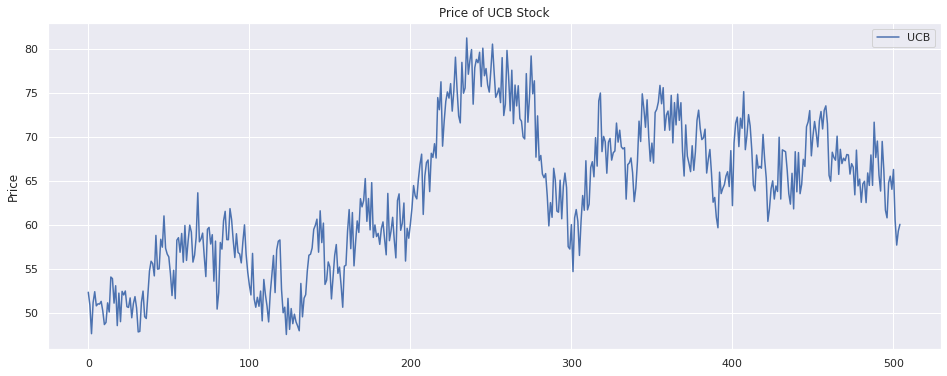

In [18]:
plt.rcParams["figure.figsize"] = (16,6)
ax = sns.lineplot(data=scaler_dict['UCB'].inverse_transform(data_dict['UCB']))
ax.set_title('Price of UCB Stock')
ax.set_ylabel('Price')
ax.legend(['UCB'])


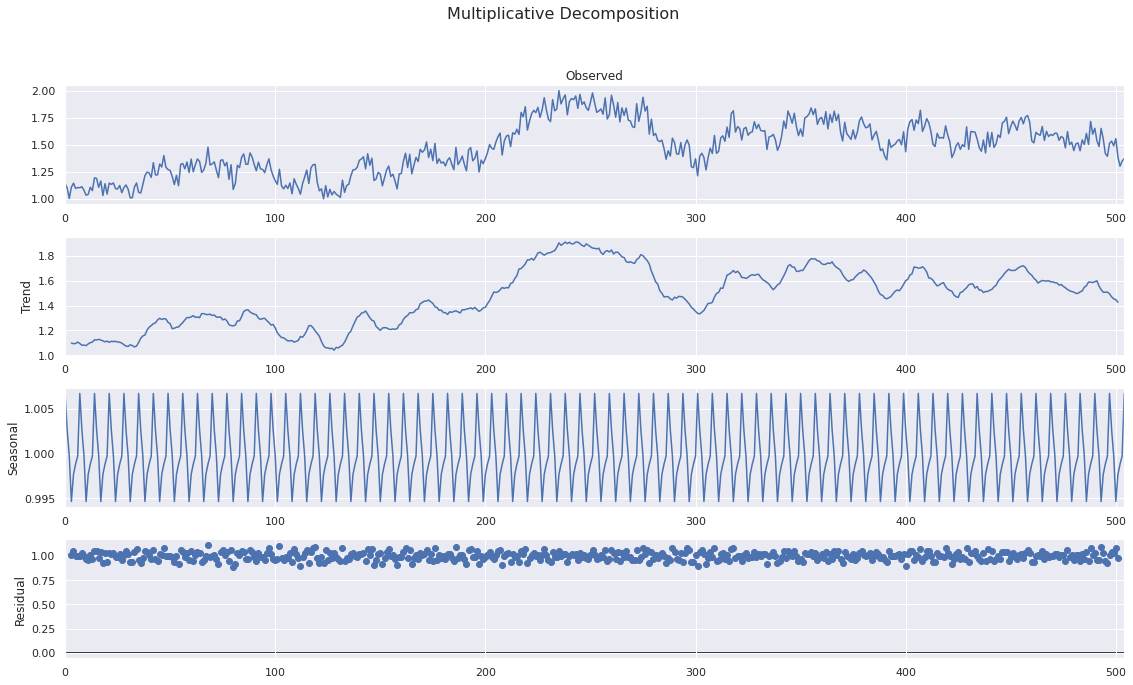

In [22]:
plt.rcParams["figure.figsize"] = (16,10)
multiplicative_decomposition = seasonal_decompose(data_dict['UCB'], model='multiplicative', period=7)

multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [24]:
data_dict_splited = dict()

for symbol,prices in data_dict.items():
    data_dict_splited[symbol] = prepare_data(prices)

data_dict_dataloader = dict()

for symbol,prices in data_dict_splited.items():
    X_train,Y_train,X_test,Y_test = prices
    
    trainset = Dataset(X_train,Y_train)
    trainloader = DataLoader(trainset, batch_size=len(X_train),shuffle=False)
    
    testset = Dataset(X_test,Y_test)
    testloader = DataLoader(testset, batch_size=len(X_test),shuffle=False)
    
    data_dict_dataloader[symbol] = [trainloader,testloader]


 99%|██████████████████████████████████████▌| 500/505 [00:00<00:00, 3360.03it/s]


In [29]:
pd.DataFrame(data_dict_splited['UCB'][0],columns=['day 1','day 2','day 3','day 4','day 5','is monotonic?','slope','change rate','weighted Avg','day of week']).head(10)

,day 1,day 2,day 3,day 4,day 5,is monotonic?,slope,change rate,weighted Avg,day of week
0,1.142476,1.099526,1.002666,1.107524,1.144254,0.0,0.001155,1.001556,0.837614,1.0
1,1.099526,1.002666,1.107524,1.144254,1.096564,0.0,0.013566,0.997306,0.835747,2.0
2,1.002666,1.107524,1.144254,1.096564,1.103377,0.0,0.019046,1.100443,0.839309,3.0
3,1.107524,1.144254,1.096564,1.103377,1.102488,0.0,-0.005095,0.995453,0.845433,4.0
4,1.144254,1.096564,1.103377,1.102488,1.111671,0.0,-0.005924,0.971525,0.845351,5.0
5,1.096564,1.103377,1.102488,1.111671,1.079384,0.0,-0.002607,0.984333,0.837123,6.0
6,1.103377,1.102488,1.111671,1.079384,1.033472,0.0,-0.016291,0.936644,0.822975,7.0
7,1.102488,1.111671,1.079384,1.033472,1.040581,0.0,-0.020201,0.943847,0.811762,1.0
8,1.111671,1.079384,1.033472,1.040581,1.106635,0.0,-0.004887,0.995470,0.816871,2.0
9,1.079384,1.033472,1.040581,1.106635,1.075829,0.0,0.006605,0.996707,0.815752,3.0


In [30]:
model_dict = dict()

for symbol,dloader in tqdm(data_dict_dataloader.items()): # for each symbol it runs the whole process
    #
    rnn_losses = []
    cnn_losses = []
    val_error = []
    curr_err_rnn = np.inf
    curr_err_cnn = np.inf
    trainloader = dloader[0]
    testloader = dloader[1]
    
    # initialze models
    cnn_predictor=CNN_predictor().to(device)
    cnn_predictor.apply(weights_init)
    loss_fn_cnn = torch.nn.MSELoss()
    cnn_predictor_optimizer = torch.optim.Adam(cnn_predictor.parameters(), lr=0.001,betas=(0.5, 0.999))
    loss_fn_cnn=loss_fn_cnn.to(device)
    
    rnn_predictor = RNN_predictor(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    loss_fn_rnn = torch.nn.MSELoss()
    rnn_predictor_optimiser = torch.optim.Adam(rnn_predictor.parameters(), lr=0.005)
    loss_fn_rnn=loss_fn_rnn.to(device)
    
    
    for epoch in range(num_epochs):
        X,Y = iter(trainloader).next()
            
        batchsize = X.shape[0]
        
        # CNN part
        
        output_cnn = cnn_predictor(X.reshape(batchsize,-1,10,1))
        errCnn = loss_fn_cnn(output_cnn, Y.reshape(-1,1))
        cnn_predictor_optimizer.zero_grad()
        errCnn.backward()
        errCnn_mean = errCnn.mean().item()
        cnn_predictor_optimizer.step() 
        
        # RNN part
        
        output_rnn = rnn_predictor(X.reshape(-1,1,10))
        errRnn = loss_fn_rnn(output_rnn, Y.reshape(-1,1))
        rnn_predictor_optimiser.zero_grad()
        errRnn.backward()
        errRnn_mean = errRnn.mean().item()
        rnn_predictor_optimiser.step() 
          
        # Evaluation part for early stopping
        with torch.no_grad():
            x,y = iter(testloader).next()
            cnn_predictor.eval() 
            y_p = cnn_predictor(x.reshape(-1,1,10,1))
            val_err_cnn=loss_fn_cnn(y_p, y.reshape(-1,1))
            val_err_cnn = val_err_cnn.mean().item()
            val_error.append(val_err_cnn)
            cnn_predictor.train()
            
        with torch.no_grad():
            x,y = iter(testloader).next()
            rnn_predictor.eval() 
            y_p = rnn_predictor(x.reshape(-1,1,10))
            val_err_rnn=loss_fn_rnn(y_p, y.reshape(-1,1))
            val_err_rnn = val_err_rnn.mean().item()
            rnn_predictor.train()
            
        cnn_losses.append(errCnn_mean)
        rnn_losses.append(errRnn_mean)
        
        if curr_err_cnn > val_err_cnn :
            idx_cnn = epoch
            torch.save(cnn_predictor.state_dict(), path_cnn+'_'+symbol)
            curr_err_cnn = val_err_cnn
            
            
        if curr_err_rnn > val_err_rnn :
            idx_rnn = epoch
            torch.save(rnn_predictor.state_dict(), path_rnn+'_'+symbol)
            curr_err_rnn = val_err_rnn
    #save the best models
    cnn_predictor.load_state_dict(torch.load(path_cnn+'_'+symbol))
    rnn_predictor.load_state_dict(torch.load(path_rnn+'_'+symbol))
    
    #ML models
    knn = KNeighborsRegressor(n_neighbors=2,n_jobs=-1,weights='distance',algorithm='brute')
    knn.fit(X.cpu().detach().numpy(), Y.cpu().detach().numpy())
    
    rfRegressor = RandomForestRegressor(min_samples_split=5, random_state=0,n_jobs=-1)
    rfRegressor.fit(X.cpu().detach().numpy(), Y.cpu().detach().numpy())
    
    
    model_dict[symbol] = [cnn_predictor,rnn_predictor,knn,rfRegressor]
    

100%|███████████████████████████████████████████| 10/10 [07:13<00:00, 43.39s/it]


In [31]:
#inference as a sample symbol

with torch.no_grad():
    x,y = iter(data_dict_dataloader['UCB'][0]).next() 
    cnn_predictor=model_dict['UCB'][0] 
    cnn_predictor.eval()
    y_p_cnn = cnn_predictor(x.reshape(-1,1,10,1))
    cnn_predictor.train()
    
    rnn_predictor=model_dict['UCB'][1]
    rnn_predictor.eval()
    y_p_rnn = rnn_predictor(x.reshape(-1,1,10))
    rnn_predictor.train()
    
    knn=model_dict['UCB'][2]
    y_p_knn = knn.predict(x.cpu().detach().numpy())
    
    rfReg=model_dict['UCB'][3]
    y_p_rfr = rfReg.predict(x.cpu().detach().numpy())
    
    y_p_cnn= y_p_cnn.cpu().detach().numpy().reshape(-1)
    y_p_rnn= y_p_rnn.cpu().detach().numpy().reshape(-1)
    y_p_knn = y_p_knn.reshape(-1)
    y_p_rfr = y_p_rfr.reshape(-1)
    
    y_p_final = (y_p_cnn+y_p_rnn+y_p_knn+y_p_rfr)/4 #averaging on 4 model's results to get final price


Text(0, 0.5, 'Price')

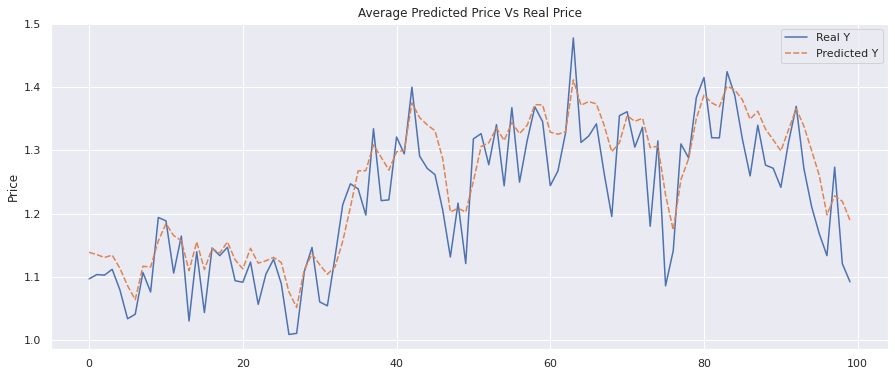

In [33]:
realVsPredicted = pd.DataFrame()
realVsPredicted['Real Y'] = y.cpu().detach().numpy().reshape(-1)
realVsPredicted['Predicted Y'] = y_p_final

plt.rcParams["figure.figsize"] = (15,6)
ax=sns.lineplot(data =realVsPredicted.iloc[:100,:])
ax.set_title('Average Predicted Price Vs Real Price')
ax.set_ylabel('Price')


Text(0, 0.5, 'Error')

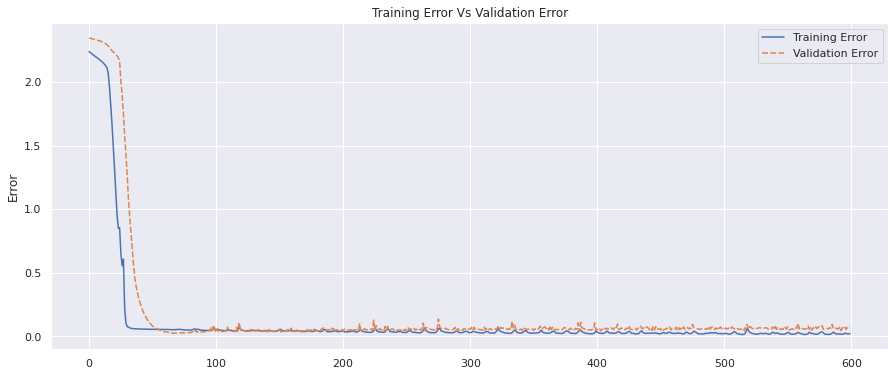

In [36]:

vserror = pd.DataFrame()
vserror['Training Error'] = cnn_losses
vserror['Validation Error'] = val_error

plt.rcParams["figure.figsize"] = (15,6)
ax=sns.lineplot(data =vserror)
ax.set_title('Training Error Vs Validation Error')
ax.set_ylabel('Error')

#one point: model saves best model based on validation performance.

In [37]:

decision_dict=dict()


for symbol,value in data_dict.items():
    df_value=pd.DataFrame()
    df_value['price'] = value.reshape(-1)
    decision_dict[symbol] = np.where(df_value['price'].shift(-1) > df_value['price'], 1, 0).reshape(-1,1)


In [38]:

def trade(prices,symbol,daysOfweek):
    prices.extend(list(extendedFeature(prices)))
    prices.append(daysOfweek)
    prices_tensor = torch.from_numpy(np.array(prices)).to(device)
    cnn =model_dict[symbol][0]
    rnn =model_dict[symbol][1]
    knn =model_dict[symbol][2]
    rfr =model_dict[symbol][3]
    cnn.eval()
    rnn.eval()
    nextday_cnn = cnn(prices_tensor.reshape(-1,1,10,1)).cpu().detach().numpy()[0]
    nextday_rnn =  rnn(prices_tensor.reshape(1,1,10)).cpu().detach().numpy()[0]
    nextday_knn =  knn.predict(np.array(prices).reshape(1,-1))[0]
    nextday_rfr =  rfr.predict(np.array(prices).reshape(1,-1))[0]
    
    next_day = (nextday_cnn+nextday_rnn+nextday_knn+nextday_rfr)/4
    
    #if predicted price is greater than today's price then BUY otherwise SELL
    if next_day > prices[4]: 
        return 1 #buy
    elif next_day > prices[4]:
        return 0 #sell
    else:
        return -1 #keep

In [53]:
prices = data_dict_splited['UCB'][0][0][:5] #data points
prices

array([1.1424763 , 1.09952607, 1.00266588, 1.1075237 , 1.14425355])

In [50]:
trade(prices.tolist(),'UCB',1)

-1

In [55]:
data_dict_splited['UCB'][0][1][:5][-1]

1.096563981042654

In [56]:
#As you can see the model predicts action (Buy or Sell) correctly